# Practica semanal individual



## Instalación de river


In [30]:
!pip install river

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [2]:
import time
import pandas as pd
from river import stream, tree, metrics, evaluate, drift, naive_bayes,preprocessing,ensemble
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


## 1. Introducción

El conjunto de datos Adult del UCI Machine Learning Repository recoge información demográfica y laboral de personas (edad, nivel educativo, tipo de empleo, horas de trabajo, etc.) junto con una etiqueta binaria que indica si sus ingresos anuales superan los 50 000 USD.


## 1.1 Carga del CSV y vista preliminar


In [3]:
csv_file = "adult.csv"

# Carga inicial solo para inspección
df = pd.read_csv(csv_file)
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


# 2. Objetivo
Aunque se trata de un dataset estático, presenta varias características que lo hacen ideal para simular un flujo de datos:

Naturaleza temporal implícita: los registros reflejan una realidad socioeconómica que, en la práctica, puede evolucionar a lo largo del tiempo.

Tamaño moderado pero suficiente: permite iterar muchas instancias de forma eficiente, como si fueran llegadas sucesivas de información de nuevos individuos.

Problema de clasificación binaria realista: predecir si una persona supera un umbral de ingresos es un caso de uso frecuente en sistemas de recomendación de créditos, análisis de riesgo o planificación social.

El objetivo de este trabajo consiste en replicar condiciones cercanas a un sistema en producción que recibe datos demográficos en tiempo real, facilitando la transición a un entorno real de big data.

## 2.1 Simular flujo de datos
Transformamos el CSV en un generador que emite cada fila como un registro de flujo.
La columna `income` se convierte a binaria (1 si >50K, 0 en caso contrario).

In [4]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={
        "income": lambda x: 1 if ">50K" in str(x) else 0
    }
)

# 3. Desarrollo

## 3.1 Función para elegir el modelo
Permite seleccionar entre HDT, HAT o EFDT.

In [9]:
def elegir_modelo(nombre_modelo: str):
    nombre = nombre_modelo.lower()
    if nombre == "hdt":
        return tree.HoeffdingTreeClassifier()
    elif nombre == "hat":
        return tree.HoeffdingAdaptiveTreeClassifier() # rolling para ver el accuracy en las últimas n instancias
    elif nombre == "efdt":
        return tree.ExtremelyFastDecisionTreeClassifier()
    else:
        raise ValueError("Modelo no reconocido. Usa: 'HDT', 'HAT' o 'EFDT'.")

# 3.2 Función para elegir el detector de drift

Permite seleccionar entre DDM, 

In [ ]:
def elegir_detector(nombre: str):
    if nombre == "DDM":
        return drift.binary.DDM()
    elif nombre == "ADWIN":
        return drift.ADWIN()
    elif nombre == "HDDM_W":
        return drift.binary.HDDM_W()
    elif nombre == "HDDM_A":
        return drift.binary.HDDM_A()
    elif nombre == "KSWIN":
        return drift.KSWIN(alpha=0.01, window_size=200, stat_size=50) #AJUSTABLE
    elif nombre =="PH":
       return drift.PageHinkley()
    else:
        raise ValueError(
            "Detector no reconocido. Usa: 'DDM', 'ADWIN', 'HDDM_W', 'KSWIN' o 'PH'."
        )


## 3.3 Evaluación con validación progresiva
`evaluate.progressive_val_score` realiza el ciclo test-then-train automáticamente:
1. Predice la instancia entrante.
2. Actualiza la métrica.
3. Entrena el modelo.

In [7]:
def evaluar_modelo(data, modelo_nombre):
    modelo = elegir_modelo(modelo_nombre)
    metricas = metrics.Accuracy()
    print(f"*** Evaluación con modelo: {modelo_nombre.upper()} ***\n")
    resultado = evaluate.progressive_val_score(
        dataset=data,
        model=modelo,
        metric=metricas,
        print_every=1000  # imprime cada 1000 instancias
    )
    print(f"Accuracy final: {resultado.get():.4f}")
    return resultado.get()

# 3.4 Evaluación con detección de drift

Cuando se detecta un drift, el modelo entrenado con datos anteriores deja de representar la realidad actual, por lo que en el código reinicio el modelo cada vez que detecta un concept drift. Es cierto que, justo después de reiniciarlo, el modelo tiene pocos ejemplos y su rendimiento baja. Pero este tiempo de bajo rendimiento es preferible a mantener un modelo que predice sistemáticamente mal debido a un cambio de distribución y en el contexto de nuestro sistema no necesitamos tener un modelo preparado en todo momento, sino que es preferible asegurarnos un mejor modelo a la larga. Más adelante, con el uso de ensembles este problema se solucionaría.

In [ ]:
def evaluar_modelo_con_drift(data_stream, modelo_nombre, detector_nombre, delay):

    modelo = elegir_modelo(modelo_nombre)
    detector = elegir_detector(detector_nombre)

    acc = metrics.Accuracy()

    print(f"*** Evaluación con modelo {modelo_nombre.upper()} "
          f"y detector {detector_nombre.upper()} ***\n")

    for i, (X, y) in enumerate(data_stream, start=1):
        
        y_pred = modelo.predict_one(X)
        
        acc.update(y, y_pred)

        # Actualizar detector con error (1 si fallo, 0 si acierto)
        detector.update(int(y_pred != y))

        if detector.drift_detected:
            print(f"[Drift detectado en instancia {i}] "
                    f"Accuracy acumulada antes de reinicio: {acc.get():.4f}")
            # Reiniciar modelo y detector
            modelo = elegir_modelo(modelo_nombre)
            detector = elegir_detector(detector_nombre)

        modelo.learn_one(X, y)

        if i % 1000 == 0:
            print(f"Instancia {i} | Accuracy: {acc.get():.4f}")

        if delay > 0:
            time.sleep(delay)

    print(f"\nAccuracy final: {acc.get():.4f}")
    return acc.get()


## 3.5 Ejecutar evaluación HDT

In [38]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo(data_stream, modelo_nombre="HDT")

*** Evaluación con modelo: HDT ***

[1,000] Accuracy: 89.89%
[2,000] Accuracy: 91.60%
[3,000] Accuracy: 91.93%
[4,000] Accuracy: 91.65%
[5,000] Accuracy: 89.88%
[6,000] Accuracy: 88.16%
[7,000] Accuracy: 87.04%
[8,000] Accuracy: 86.37%
[9,000] Accuracy: 85.62%
[10,000] Accuracy: 84.68%
[11,000] Accuracy: 84.42%
[12,000] Accuracy: 84.18%
[13,000] Accuracy: 83.87%
[14,000] Accuracy: 83.53%
[15,000] Accuracy: 83.38%
[16,000] Accuracy: 83.27%
[17,000] Accuracy: 83.26%
[18,000] Accuracy: 82.95%
[19,000] Accuracy: 82.66%
[20,000] Accuracy: 82.58%
[21,000] Accuracy: 82.60%
[22,000] Accuracy: 82.62%
[23,000] Accuracy: 82.49%
[24,000] Accuracy: 82.42%
[25,000] Accuracy: 82.31%
[26,000] Accuracy: 82.21%
[27,000] Accuracy: 82.13%
[28,000] Accuracy: 82.11%
[29,000] Accuracy: 82.09%
[30,000] Accuracy: 82.06%
[31,000] Accuracy: 82.05%
[32,000] Accuracy: 81.95%
[32,561] Accuracy: 81.94%
Accuracy final: 0.8194


0.8194103194103194

Se obtiene un Accuracy =~ 0.82 sin detección de drift.

# 3.6 Ejecutar evaluación HAT

In [12]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo(data_stream, modelo_nombre="HAT")

*** Evaluación con modelo: HAT ***

[1,000] Accuracy: 85.09%
[2,000] Accuracy: 74.34%
[3,000] Accuracy: 72.89%
[4,000] Accuracy: 73.92%
[5,000] Accuracy: 75.30%
[6,000] Accuracy: 76.01%
[7,000] Accuracy: 75.33%
[8,000] Accuracy: 75.67%
[9,000] Accuracy: 76.32%
[10,000] Accuracy: 76.67%
[11,000] Accuracy: 77.08%
[12,000] Accuracy: 77.37%
[13,000] Accuracy: 74.24%
[14,000] Accuracy: 72.21%
[15,000] Accuracy: 72.79%
[16,000] Accuracy: 73.32%
[17,000] Accuracy: 73.82%
[18,000] Accuracy: 74.08%
[19,000] Accuracy: 74.44%
[20,000] Accuracy: 74.69%
[21,000] Accuracy: 75.04%
[22,000] Accuracy: 75.26%
[23,000] Accuracy: 75.40%
[24,000] Accuracy: 75.60%
[25,000] Accuracy: 75.82%
[26,000] Accuracy: 75.90%
[27,000] Accuracy: 76.00%
[28,000] Accuracy: 76.11%
[29,000] Accuracy: 76.29%
[30,000] Accuracy: 76.39%
[31,000] Accuracy: 76.54%
[32,000] Accuracy: 76.54%
[32,561] Accuracy: 76.59%
Accuracy final: 0.7659


0.7659090909090909

El rendimiento de Hoeffding Adaptive Tree (HAT) =~ 0.79 empeora ligeramente respecto a HDT, esto podría deberse a su mecanismo de detección de drift y adaptación que introduce complejidad y posibles reseteos innecesarios.

# 3.7 Ejecutar evaluación EFDT
Finalmente esta opción fue descartada ya que, aunque mejorase los resultados, su coste computacional (más de 1 hora en mi equipo) hace que su uso no merezca la pena. 

In [ ]:
# data_stream = stream.iter_csv(
#     csv_file,
#     target="income",
#     converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
# )
# evaluar_modelo(data_stream, modelo_nombre="EFDT")

*** Evaluación con modelo: EFDT ***

[1,000] Accuracy: 89.89%
[2,000] Accuracy: 91.60%
[3,000] Accuracy: 94.06%
[4,000] Accuracy: 91.27%


KeyboardInterrupt: 

# 3.8 Evaluación HDT con detección de drift
Como HDT no es adaptativo requiere el uso de detectores de concept drift para reiniciarse en caso de que exista.

He utilizado para este caso 'DDM', 'ADWIN', 'HDDM_W'.
DDM por ser simple al estar basado en la probabilidad de error.
ADWIN al utilizar una ventana deslizante detecta tanto cambios bruscos como graduales.
Y HDDM_W por ser más ligero y eficiente que ADWIN pero más robusto que DDM.

In [ ]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='DDM', delay=0.0)


*** Evaluación con modelo HDT y detector DDM ***

[Drift detectado en instancia 148] Accuracy acumulada antes de reinicio: 0.7162
[Drift detectado en instancia 192] Accuracy acumulada antes de reinicio: 0.6875
[Drift detectado en instancia 357] Accuracy acumulada antes de reinicio: 0.7591
[Drift detectado en instancia 517] Accuracy acumulada antes de reinicio: 0.8317
[Drift detectado en instancia 908] Accuracy acumulada antes de reinicio: 0.8535
[Drift detectado en instancia 959] Accuracy acumulada antes de reinicio: 0.8561
[Drift detectado en instancia 993] Accuracy acumulada antes de reinicio: 0.8580
Instancia 1000 | Accuracy: 0.8590
[Drift detectado en instancia 1342] Accuracy acumulada antes de reinicio: 0.8905
[Drift detectado en instancia 1380] Accuracy acumulada antes de reinicio: 0.8899
[Drift detectado en instancia 1536] Accuracy acumulada antes de reinicio: 0.8652
[Drift detectado en instancia 1679] Accuracy acumulada antes de reinicio: 0.8761
Instancia 2000 | Accuracy: 0.891

0.8187094990940081

In [ ]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='ADWIN', delay=0.0)

*** Evaluación con modelo HDT y detector ADWIN ***

[Drift detectado en instancia 352] Accuracy acumulada antes de reinicio: 0.7642
[Drift detectado en instancia 576] Accuracy acumulada antes de reinicio: 0.8160
[Drift detectado en instancia 928] Accuracy acumulada antes de reinicio: 0.8394
Instancia 1000 | Accuracy: 0.8310
[Drift detectado en instancia 1120] Accuracy acumulada antes de reinicio: 0.8143
[Drift detectado en instancia 1408] Accuracy acumulada antes de reinicio: 0.8317
[Drift detectado en instancia 1568] Accuracy acumulada antes de reinicio: 0.8061
Instancia 2000 | Accuracy: 0.8435
[Drift detectado en instancia 2944] Accuracy acumulada antes de reinicio: 0.8808
Instancia 3000 | Accuracy: 0.8760
[Drift detectado en instancia 3136] Accuracy acumulada antes de reinicio: 0.8629
[Drift detectado en instancia 3328] Accuracy acumulada antes de reinicio: 0.8486
[Drift detectado en instancia 3552] Accuracy acumulada antes de reinicio: 0.8525
Instancia 4000 | Accuracy: 0.8600
[Drif

0.8246675470655078

In [ ]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HDT", detector_nombre='HDDM_W', delay=0.0)

*** Evaluación con modelo HDT y detector HDDM_W ***

[Drift detectado en instancia 144] Accuracy acumulada antes de reinicio: 0.7361
Instancia 1000 | Accuracy: 0.9110
[Drift detectado en instancia 1421] Accuracy acumulada antes de reinicio: 0.9113
[Drift detectado en instancia 1534] Accuracy acumulada antes de reinicio: 0.8983
Instancia 2000 | Accuracy: 0.9175
[Drift detectado en instancia 2929] Accuracy acumulada antes de reinicio: 0.9358
Instancia 3000 | Accuracy: 0.9297
[Drift detectado en instancia 3111] Accuracy acumulada antes de reinicio: 0.9196
[Drift detectado en instancia 3198] Accuracy acumulada antes de reinicio: 0.9174
[Drift detectado en instancia 3309] Accuracy acumulada antes de reinicio: 0.9066
[Drift detectado en instancia 3380] Accuracy acumulada antes de reinicio: 0.8982
[Drift detectado en instancia 3768] Accuracy acumulada antes de reinicio: 0.9026
Instancia 4000 | Accuracy: 0.9083
[Drift detectado en instancia 4238] Accuracy acumulada antes de reinicio: 0.9132
In

0.8179724209944412

Aunque observamos que detecta muchas veces drift, sobre todo en las primeras instancias y vemos que mejora tras reiniciar el modelo, hacia el final del dataset deja de haber esa variabilidad en el concepto y el accuracy final acaba siendo practicamente igual al obtenido sin detección de drift.

# 3.8 Evaluación de HAT con detección de drift

HAT incorpora su propio ADWIN interno para sustituir ramas cuando detecta cambios locales. Estas adaptaciones generan variaciones en la secuencia de errores que hacen que salte el detector externo, produciendo más alertas de drift, incluso sin cambios reales en la distribución. Por lo que no tiene mucho sentido utilizar un detecor externo basado en el error como DDM con HAT.

In [ ]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)
evaluar_modelo_con_drift(data_stream, modelo_nombre="HAT", detector_nombre='DDM', delay=0.0)

*** Evaluación con modelo HAT y detector DDM ***

[Drift detectado en instancia 148] Accuracy acumulada antes de reinicio: 0.7230
[Drift detectado en instancia 192] Accuracy acumulada antes de reinicio: 0.6927
[Drift detectado en instancia 358] Accuracy acumulada antes de reinicio: 0.7542
[Drift detectado en instancia 517] Accuracy acumulada antes de reinicio: 0.8279
[Drift detectado en instancia 909] Accuracy acumulada antes de reinicio: 0.8449
[Drift detectado en instancia 961] Accuracy acumulada antes de reinicio: 0.8439
[Drift detectado en instancia 995] Accuracy acumulada antes de reinicio: 0.8442
Instancia 1000 | Accuracy: 0.8450
[Drift detectado en instancia 1342] Accuracy acumulada antes de reinicio: 0.8808
[Drift detectado en instancia 1380] Accuracy acumulada antes de reinicio: 0.8804
[Drift detectado en instancia 1537] Accuracy acumulada antes de reinicio: 0.8543
[Drift detectado en instancia 1679] Accuracy acumulada antes de reinicio: 0.8660
Instancia 2000 | Accuracy: 0.882

0.8090967722121557

En este caso concreto conviene emplear KSWIN con parámetros más permisivos porque Hoeffding Adaptive Tree (HAT) ya incorpora su propio mecanismo de adaptación al concepto mediante ADWIN en las hojas. Esto significa que el modelo se reajusta de forma interna cuando detecta variaciones, sin necesidad de un detector externo muy sensible. Si KSWIN fuera demasiado estricto, podría disparar falsas alarmas ante simples fluctuaciones, provocando reacciones innecesarias sobre un clasificador que ya se está ajustando. Al configurarlo de forma más permisiva (aumentando window_size y reduciendo alpha) KSWIN se limita a señalar únicamente cambios realmente sustanciales en lugar de duplicar o entorpecer, la capacidad adaptativa que ya tiene HAT.

In [ ]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)

modelo = elegir_modelo("HAT")
detector = drift.KSWIN(alpha=0.0005, window_size=1000, stat_size=200)

acc = metrics.Accuracy()

for i, (X, y) in enumerate(data_stream, start=1):
    
    y_pred = modelo.predict_one(X)
    
    acc.update(y, y_pred)

    detector.update(int(y_pred != y))

    if detector.drift_detected:
        print(f"[Drift detectado en instancia {i}] "
                f"Accuracy acumulada antes de reinicio: {acc.get():.4f}")
        modelo = elegir_modelo("HAT")
        detector = drift.KSWIN(alpha=0.0005, window_size=1000, stat_size=200)

    modelo.learn_one(X, y)

    if i % 1000 == 0:
        print(f"Instancia {i} | Accuracy: {acc.get():.4f}")

print(f"\nAccuracy final: {acc.get():.4f}")



[Drift detectado en instancia 1000] Accuracy acumulada antes de reinicio: 0.8240
Instancia 1000 | Accuracy: 0.8240
[Drift detectado en instancia 2000] Accuracy acumulada antes de reinicio: 0.7820
Instancia 2000 | Accuracy: 0.7820
[Drift detectado en instancia 3000] Accuracy acumulada antes de reinicio: 0.8300
Instancia 3000 | Accuracy: 0.8300
Instancia 4000 | Accuracy: 0.8223
[Drift detectado en instancia 4406] Accuracy acumulada antes de reinicio: 0.8205
Instancia 5000 | Accuracy: 0.8196
Instancia 6000 | Accuracy: 0.8157
Instancia 7000 | Accuracy: 0.8140
Instancia 8000 | Accuracy: 0.8146
Instancia 9000 | Accuracy: 0.8143
Instancia 10000 | Accuracy: 0.8107
[Drift detectado en instancia 10083] Accuracy acumulada antes de reinicio: 0.8095
Instancia 11000 | Accuracy: 0.8106
Instancia 12000 | Accuracy: 0.8103
Instancia 13000 | Accuracy: 0.8105
Instancia 14000 | Accuracy: 0.8093
Instancia 15000 | Accuracy: 0.8087
Instancia 16000 | Accuracy: 0.8086
Instancia 17000 | Accuracy: 0.8095
Instanci

# Data drift
En este apartado he decidido aplicar un detector de data drift al atributo "hours-per-week"de esta forma, en un caso real podríamos ver si la distribución de las horas trabajadas por semana cambia significativamente a lo largo del tiempo, por ejemplo por una posible reducción de jornada o un aumento de la productividad en el mercado laboral.

In [ ]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={
        "income": lambda x: 1 if ">50K" in str(x) else 0,
        "hours.per.week": float    # aseguramos tipo numérico
    }
)

kswin = drift.KSWIN(alpha=0.015, window_size=500, stat_size=30)

for i, (X, y) in enumerate(data_stream, start=1):
    hours_val = float(X["hours.per.week"])

    kswin.update(hours_val)
    # Comprobamos si se detecta drift
    if kswin.drift_detected:
        print(f"[Drift detectado] Instancia {i} | hours-per-week = {hours_val}")
        kswin = drift.KSWIN(alpha=0.015, window_size=500, stat_size=30)



[Drift detectado] Instancia 503 | hours-per-week = 50.0
[Drift detectado] Instancia 1041 | hours-per-week = 25.0
[Drift detectado] Instancia 1558 | hours-per-week = 50.0
[Drift detectado] Instancia 2163 | hours-per-week = 45.0
[Drift detectado] Instancia 2679 | hours-per-week = 40.0
[Drift detectado] Instancia 3509 | hours-per-week = 40.0
[Drift detectado] Instancia 4171 | hours-per-week = 22.0
[Drift detectado] Instancia 5569 | hours-per-week = 40.0
[Drift detectado] Instancia 7061 | hours-per-week = 40.0
[Drift detectado] Instancia 10534 | hours-per-week = 40.0
[Drift detectado] Instancia 11600 | hours-per-week = 50.0
[Drift detectado] Instancia 14422 | hours-per-week = 36.0
[Drift detectado] Instancia 15721 | hours-per-week = 40.0
[Drift detectado] Instancia 17440 | hours-per-week = 40.0
[Drift detectado] Instancia 18951 | hours-per-week = 40.0
[Drift detectado] Instancia 19577 | hours-per-week = 60.0
[Drift detectado] Instancia 22520 | hours-per-week = 65.0
[Drift detectado] Instan

# 3.9 Comparación con Decision Tree por lotes

In [ ]:
df["income"] = df["income"].apply(lambda x: 1 if ">50K" in str(x) else 0)

# One-hot encoding de variables categóricas
X = pd.get_dummies(df.drop(columns="income"), drop_first=True)
y = df["income"]

# División en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

dtc = DecisionTreeClassifier(
    criterion="gini", 
    max_depth=None,      
    random_state=42
)
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy en test: {acc:.4f}")

Accuracy en test: 0.8141


En el escenario por lotes el árbol ve todo el conjunto de entrenamiento a la vez y puede construir una estructura óptima para ese conjunto.

El modelo incremental solo ve cada ejemplo en orden, aprendiendo poco a poco.

Esta limitación hace que la accuracy en el modelo incremental/online sea, en general, menor, aunque en este caso no se note demasiado esa diferencia.

# 3.10 Naive Bayes Incremental
Naive Bayes incremental es apropiado en este problema de flujo de datos porque combina simplicidad y bajo coste computacional, además nos sirve un punto de comparación valioso frente a clasificadores incrementales más elaborados como los arboles probados en los anteriores puntos del notebook. Como antes hemos observado que el dataset no cuenta con un concept drift demasiado claro, no veo necesario el uso de Fadin Factor ventanas deslizantes.

In [18]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)

#  Onehot encoding para convertir las variables categóricas en numéricas
nb_model = preprocessing.OneHotEncoder() | naive_bayes.GaussianNB()

metric = metrics.Accuracy()

accuracy_final = evaluate.progressive_val_score(
    dataset=data_stream,
    model=nb_model,
    metric=metric,
    print_every=1000
)

print(f"\n Accuracy final: {accuracy_final.get():.4f}")

[1,000] Accuracy: 70.67%
[2,000] Accuracy: 61.28%
[3,000] Accuracy: 71.72%
[4,000] Accuracy: 60.74%
[5,000] Accuracy: 53.95%
[6,000] Accuracy: 58.23%
[7,000] Accuracy: 61.38%
[8,000] Accuracy: 64.00%
[9,000] Accuracy: 65.93%
[10,000] Accuracy: 67.41%
[11,000] Accuracy: 68.76%
[12,000] Accuracy: 69.78%
[13,000] Accuracy: 70.70%
[14,000] Accuracy: 71.38%
[15,000] Accuracy: 72.02%
[16,000] Accuracy: 72.57%
[17,000] Accuracy: 73.18%
[18,000] Accuracy: 73.51%
[19,000] Accuracy: 73.93%
[20,000] Accuracy: 74.29%
[21,000] Accuracy: 74.69%
[22,000] Accuracy: 74.98%
[23,000] Accuracy: 75.19%
[24,000] Accuracy: 75.43%
[25,000] Accuracy: 75.66%
[26,000] Accuracy: 75.81%
[27,000] Accuracy: 75.99%
[28,000] Accuracy: 76.16%
[29,000] Accuracy: 76.36%
[30,000] Accuracy: 76.48%
[31,000] Accuracy: 76.67%
[32,000] Accuracy: 76.73%
[32,561] Accuracy: 76.82%

 Accuracy final: 0.7682


# 3.11 Ensembles
En este punto tiene sentido probar algún ensemble, en concreto ADWINBaggingClassifier porque combina, en un único algoritmo, dos de las ideas clave que he tratado: arboles incrementales y detección automática de concept drift. Este modelo mantiene un conjunto de HDTs que aprenden de manera online y, al mismo tiempo, incorpora ADWIN como detector interno de cambios. ADWIN monitoriza la secuencia de errores de cada árbol y, cuando detecta que la distribución de esos errores ha variado significativamente, asume que el concepto ha cambiado y reemplaza el solo el árbol afectado por uno nuevo. Así, el clasificador se adapta de forma continua a posibles variaciones en los datos del flujo sin que tengamos que reiniciar manualmente el entrenamiento ni decidir cuándo ocurren los cambios. Esto lo convierte en una opción muy adecuada para escenarios en los que esperamos concept drift.

Como ya hemos concluído antes, el conjunto de datos utilizado no presenta un drift muy acusado por lo que la aplicación de este tipo de modelos podría estar "sobreactuando" y aumentando la complijidad de un problema más o menos estable, lo que podría explicar la ligera bajada de rendimiento frente a modelos sencillos.

In [16]:
data_stream = stream.iter_csv(
    csv_file,
    target="income",
    converters={"income": lambda x: 1 if ">50K" in str(x) else 0}
)

model = ensemble.ADWINBaggingClassifier(
    model=tree.HoeffdingTreeClassifier(),
    n_models=5,    
    seed=42
)

metric = metrics.Accuracy()

print("*** Evaluación ADWIN BaggingClassifier ***\n")

accuracy_final = evaluate.progressive_val_score(
    dataset=data_stream,
    model=model,
    metric=metric,
    print_every=1000
)
print(f"\nAccuracy final: {metric.get():.4f}")


*** Evaluación ADWIN BaggingClassifier ***

[1,000] Accuracy: 70.97%
[2,000] Accuracy: 75.59%
[3,000] Accuracy: 81.26%
[4,000] Accuracy: 83.95%
[5,000] Accuracy: 81.92%
[6,000] Accuracy: 81.53%
[7,000] Accuracy: 81.40%
[8,000] Accuracy: 79.41%
[9,000] Accuracy: 79.66%
[10,000] Accuracy: 79.73%
[11,000] Accuracy: 79.91%
[12,000] Accuracy: 79.98%
[13,000] Accuracy: 80.06%
[14,000] Accuracy: 79.86%
[15,000] Accuracy: 79.35%
[16,000] Accuracy: 79.00%
[17,000] Accuracy: 79.16%
[18,000] Accuracy: 79.13%
[19,000] Accuracy: 79.16%
[20,000] Accuracy: 78.93%
[21,000] Accuracy: 78.62%
[22,000] Accuracy: 78.48%
[23,000] Accuracy: 78.13%
[24,000] Accuracy: 77.80%
[25,000] Accuracy: 77.84%
[26,000] Accuracy: 77.83%
[27,000] Accuracy: 77.84%
[28,000] Accuracy: 77.89%
[29,000] Accuracy: 77.98%
[30,000] Accuracy: 77.89%
[31,000] Accuracy: 77.81%
[32,000] Accuracy: 77.39%
[32,561] Accuracy: 76.73%

Accuracy final: 0.7673


# 4 Conclusiones

En esta práctica se ha demostrado la viabilidad de modelos de clasificación incremental para el problema de predicción de ingresos en el conjunto de datos utilizado, tratándolo como un flujo de datos continuo.


Hoeffding Tree (HDT) ofreció un rendimiento sólido y estable.

Hoeffding Adaptive Tree (HAT), diseñado para adaptarse a concept drift, no superó necesariamente a HDT en este conjunto. Esto nos sugiere que el dataset no presenta un concept drift claro.

Detección de concept drift

Se probaron detectores como DDM, ADWIN y KSWIN.

Para HAT, que ya incorpora adaptación interna, utilicé KSWIN con parámetros más permisivos para monitorizar el flujo sin reinicios demasiado frecuentes, complementando la capacidad adaptativa del modelo sin interferir en exceso, esta aproximación demostró mejores resultados que aplicando el mismo reseteo que a un HDT.

Deteccion de Data Drift 

La monitorización de la variable específica hours-per-week, evidenció que la distribución de ciertas características puede variar en el tiempo, en este caso por una posible nueva ley de reducción de jornada o por un aumento de la productividad en el mercado laboral.

La prueba realizada con ensembles incrementales, concretamente con ADWINBaggingClassifier, muestra que en flujos de datos como el utilizado en este trabajo, donde la distribución de los datos es relativamente estacionaria, el coste de mantener varios modelos y reiniciarlos cuando ADWIN detecta cambios puede traducirse en una ligera pérdida de precisión frente a un único Hoeffding Tree. En otras palabras, la ventaja de los ensembles no radica en mejorar la exactitud en problemas ligeramente estáticos, sino en ofrecer robustez y resiliencia cuando las condiciones cambian realmente. En escenarios más dinámicos o sujetos a variaciones frecuentes, se esperaría que estos métodos superen a los modelos individuales, justificando su mayor complejidad computacional.

# Clustering incrmental
A continuación utilizaremos el mismo datasets para realizar aprendizaje no supervisado, para ello eliminaremos la etiqueta utilizada antriormente para clasificación supervisada (ingresos > 50.000 o < 50.000). Con esta prueba buscamos que el sisitema agrupe los datos de los individuos intentando formar cluster que representarían grupos socioeconómicos distintos dentro de la sociedad representada en este dataset

In [4]:
## Preparación de datos para clustering incremental

# Cargar el dataset completo
df_clustering = pd.read_csv(csv_file)

# Eliminar la columna 'income' ya que vamos a hacer clustering no supervisado
df_clustering = df_clustering.drop(columns=['income'])

# Mostrar las primeras filas para verificar
print("Dataset para clustering - primeras 5 filas:")
print(df_clustering.head())
print(f"\nDimensiones del dataset: {df_clustering.shape}")

# Crear un stream de datos sin la variable objetivo
clustering_stream = stream.iter_csv(
    csv_file,
    target=None,  # Sin variable objetivo para clustering
    drop=["income"]  # Eliminar explícitamente la columna income
)

# Verificar una instancia del stream
print("\nPrimera instancia del stream de clustering:")
for i, (X, _) in enumerate(clustering_stream):
    if i == 0:  # Solo mostrar la primera instancia
        print(X)
        break

Dataset para clustering - primeras 5 filas:
   age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country  
0          4356              40  United-States  
1          4356 

Distribución de clústeres:

Clúster 0:
<=50K    1.0
Name: proportion, dtype: float64

Clúster 1:
<=50K    0.768
>50K     0.232
Name: proportion, dtype: float64

Ejemplo de asignaciones:
      income  cluster
14160  <=50K        0
27048  <=50K        1
28868  <=50K        1
5667   <=50K        0
7827   <=50K        1
15382  <=50K        1
4641   <=50K        1
8943   <=50K        1
216    <=50K        1
5121   <=50K        1


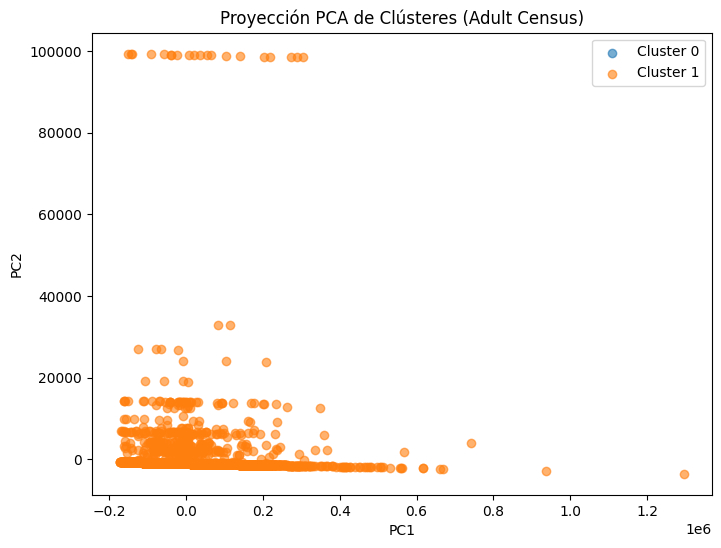

In [6]:
import pandas as pd
from river import cluster, preprocessing
from collections import defaultdict

# 1. Cargar solo una muestra (para que no tarde tanto)
df = pd.read_csv("adult.csv").sample(5000, random_state=42)

# 2. Selección de variables más manejable
X = df.drop(columns=["income"])
y = df["income"]

# 3. Flujo instancia por instancia
data_stream = (row.to_dict() for _, row in X.iterrows())

# 4. Modelo de clustering incremental
modelo = (
    preprocessing.OneHotEncoder() |
    preprocessing.StandardScaler() |
    cluster.KMeans(n_clusters=2, seed=42)
)

# 5. Guardar asignaciones
asignaciones = []
cluster_labels = defaultdict(list)

for xi, yi in zip(data_stream, y):
    cluster_id = modelo.predict_one(xi)
    asignaciones.append(cluster_id)
    cluster_labels[cluster_id].append(yi)
    modelo.learn_one(xi)

# 6. Analizar resultados
print("Distribución de clústeres:")
for cid, valores in cluster_labels.items():
    distrib = pd.Series(valores).value_counts(normalize=True).round(3)
    print(f"\nClúster {cid}:")
    print(distrib)

df["cluster"] = asignaciones
print("\nEjemplo de asignaciones:")
print(df[["income", "cluster"]].head(10))

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 🔹 Usamos solo las variables numéricas + one-hot encoding para graficar
X_encoded = pd.get_dummies(X, drop_first=True)

# 🔹 Reducimos a 2 dimensiones con PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_encoded)

# 🔹 Creamos un DataFrame con los componentes y los clusters asignados
df_plot = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Cluster": df["cluster"].astype(str),
    "Income": df["income"].astype(str)  # opcional, para colorear por income
})

# 🔹 Gráfico PCA con clústeres
plt.figure(figsize=(8, 6))
for c in df_plot["Cluster"].unique():
    subset = df_plot[df_plot["Cluster"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", alpha=0.6)

plt.title("Proyección PCA de Clústeres (Adult Census)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()



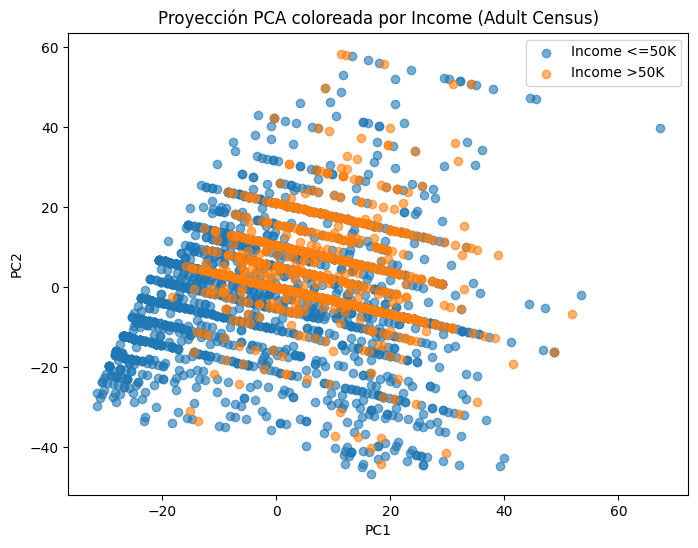

In [11]:
# 🔹 Gráfico PCA coloreado por la etiqueta real (income)
plt.figure(figsize=(8, 6))
for val in df_plot["Income"].unique():
    subset = df_plot[df_plot["Income"] == val]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Income {val}", alpha=0.6)

plt.title("Proyección PCA coloreada por Income (Adult Census)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()
